# Dean Property Consulting 2024

## Imports

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [27]:
# load dataset
df = pd.read_csv('../data/df_lownull.csv', parse_dates=['DATE'])
df = df.drop(columns=['Unnamed: 0'])

# clean column names (lowercase and remove spaces)
df.columns = [col.lower().replace(' ', '').replace('/', '_') for col in df.columns]

# clean and convert columns
df['annual$'] = df['annual$'].str.replace('$', '').str.replace(',', '').astype(float)
df['date'] = df['date'].astype('datetime64[ns]')
df['sale_ask'] = df['sale_ask'].astype('float')

# clean the 'sf' column before filtering
df['sf'] = (
    df['sf']
    .str.replace(',', '')             # remove commas
    .str.replace(' \t-  ', '')        # remove tabs
    .str.replace(' ', '')             # remove spaces
    .str.replace('$', '')             # remove $ signs
    .str.replace('sf', '')            # remove extra letters
    .replace('', np.nan)              # replace empty strings with nan
)
df['sf'] = df['sf'].astype('float')  # convert 'sf' to float

# drop rows with nan values in specific columns
df = df.dropna(subset=['date', 'sale_ask', 'units', 'floors', 'sf', 'annual$'])

# drop rows where any of 'sf', 'units', or 'floors' equals zero
df = df[~(df[['sf', 'units', 'floors']] == 0).any(axis=1)]

# update and convert remaining columns
df.at[12080, 'units'] = 1
df['units'] = df['units'].astype('float')
df['floors'] = df['floors'].astype('float')

# check results
print(df.shape)
df[df['sf'] == 0]  # should return an empty dataframe

(39687, 6)


,date,sale_ask,units,floors,sf,annual$


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39687 entries, 0 to 40683
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      39687 non-null  datetime64[ns]
 1   sale_ask  39687 non-null  float64       
 2   units     39687 non-null  float64       
 3   floors    39687 non-null  float64       
 4   sf        39687 non-null  float64       
 5   annual$   39687 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 3.1 MB


In [29]:
df.head()

,date,sale_ask,units,floors,sf,annual$
0,2010-01-03,770000.0,1.0,2.5,2722.0,36033.0
1,2010-01-06,1397478.0,2.0,3.0,3780.0,63202.0
2,2010-01-10,505000.0,1.0,1.0,800.0,30089.0
3,2010-01-11,450000.0,1.0,1.0,650.0,31473.0
4,2010-01-11,1530000.0,3.0,3.0,3200.0,69400.0


In [30]:
# save 
df.to_csv('../data/df_lownull_clean.csv')

## Feature Engineering

We want to extract some helpful information, like year, month, day of week, and quarter from the dataset.

In [31]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.day_of_week
df['quarter'] = df['date'].dt.quarter
df.head()

,date,sale_ask,units,floors,sf,annual$,year,month,day_of_week,quarter
0,2010-01-03,770000.0,1.0,2.5,2722.0,36033.0,2010,1,6,1
1,2010-01-06,1397478.0,2.0,3.0,3780.0,63202.0,2010,1,2,1
2,2010-01-10,505000.0,1.0,1.0,800.0,30089.0,2010,1,6,1
3,2010-01-11,450000.0,1.0,1.0,650.0,31473.0,2010,1,0,1
4,2010-01-11,1530000.0,3.0,3.0,3200.0,69400.0,2010,1,0,1


## Model selection

To select the appropriate model, we first should inspect the nature of the data with some plotting. Let's see what the sales per month are like:

In [32]:
# group data and prepare for plotting
sales_per_month = df.groupby(['year', 'month']).size()
sales_per_month = sales_per_month.reset_index(name='count')
sales_per_month.columns = ['year', 'month', 'count']
sales_per_month['year_month'] = sales_per_month['year'].astype(str) + '-' + sales_per_month['month'].astype(str).str.zfill(2)

# create custom tick labels
tick_labels = [
    label if month in [1, 6] else ""  # Show label only for January and June
    for label, month in zip(sales_per_month['year_month'], sales_per_month['month'])
]

# create the bar chart
fig = go.Figure()

fig.add_trace(go.Bar(
    x=sales_per_month['year_month'],
    y=sales_per_month['count'],
    marker_color='coral',
    name='Sales Per Month',
    hovertext=[f"{ym}<br>Count: {count}" for ym, count in zip(sales_per_month['year_month'], sales_per_month['count'])],  # add hover info
    hoverinfo="text"  # display hovertext
))

# add vertical lines for the start of each year
for idx in sales_per_month[sales_per_month['month'] == 1].index:
    fig.add_shape(
        type="line",
        x0=sales_per_month.loc[idx, 'year_month'],
        x1=sales_per_month.loc[idx, 'year_month'],
        y0=0,
        y1=sales_per_month['count'].max(),
        line=dict(color="cornflowerblue", width=1)
    )

# customize the layout
fig.update_layout(
    title='Sales Per Month',
    xaxis=dict(
        title='Year-Month',
        tickvals=sales_per_month['year_month'],  # keep all positions for x-ticks
        ticktext=tick_labels,  # apply filtered labels
        tickangle=45
    ),
    yaxis=dict(title='Count'),
    margin=dict(l=40, r=40, t=40, b=40),
    plot_bgcolor='white'
)

fig.show()

It seems like overall, more sales are done in the warmer months than the colder ones, so there would be a seasonal signal in the data.

I will work with the LSTM model in PyTorch. LSTM is a deep learning method for time series analysis.

### LSTM with PyTorch

#### Prepare data

Convert dataset into a sequence suitable for LSTM.

In [22]:
df = df.sort_values('date')

# define features and target
target_column = 'sale_ask'
features = [col for col in df.columns if col not in ['date', 
                                                     'year', 
                                                     'month', 
                                                     'day_of_week', 
                                                     'quarter']]

Given that this is a time-series task, we won't be using the normal `scikit-learn` `train_test_split`. We will instead need to split the data by time to ensure that future data points are not used in training the model.

In [25]:
# define split sizes (e.g., 70% train, 20% validation, 10% test)
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.2)

# Create splits
train_df = df.iloc[:train_size]
val_df = df.iloc[train_size:train_size + val_size]
test_df = df.iloc[train_size + val_size:]

print("train shape:", train_df.shape)
print("val shape:  ", val_df.shape)
print("test shape :", test_df.shape)

train shape: (27780, 10)
val shape:   (7937, 10)
test shape : (3970, 10)


##### Normalize the data

In [34]:
# normalize features and target
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# fit and transform on training data
train_features = feature_scaler.fit_transform(train_df[features])
train_target = target_scaler.fit_transform(train_df[[target_column]])

# transform validation and test sets
val_features = feature_scaler.transform(val_df[features])
val_target = target_scaler.transform(val_df[[target_column]])

test_features = feature_scaler.transform(test_df[features])
test_target = target_scaler.transform(test_df[[target_column]])

##### Create sequences

LSTMs require sequences, or sliding windows of time intervals for the features and correspoding targets.

In [35]:
def create_sequences(features, target, seq_len):
    X, y = [], []
    for i in range(len(features) - seq_len):
        X.append(features[i:i+seq_len])
        y.append(target[i+seq_len])
    return np.array(X), np.array(y)

# define sequence length
seq_len = 30  # Example: Use 30 days of data to predict the next day

# create sequences
X_train, y_train = create_sequences(train_features, train_target, seq_len)
X_val, y_val = create_sequences(val_features, val_target, seq_len)
X_test, y_test = create_sequences(test_features, test_target, seq_len)

##### Convert to PyTorch tensors

Convert the datasets to PyTorch tensors:

In [36]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

### PyTorch processing

#### Create the PyTorch Dataset and DataLoader:

In [37]:
class TimeSeriesDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# Create datasets
train_dataset = TimeSeriesDataset(X_train_tensor, y_train_tensor)
val_dataset = TimeSeriesDataset(X_val_tensor, y_val_tensor)
test_dataset = TimeSeriesDataset(X_test_tensor, y_test_tensor)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

### Define the LSTM model:

In [38]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # Take the output of the last time step
        last_out = lstm_out[:, -1, :]
        return self.fc(last_out)

# Define model parameters
input_dim = len(features)
hidden_dim = 64
output_dim = 1
num_layers = 2

model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers)

#### Train the model

In [39]:
criterion = nn.MSELoss()  # Use MSE for regression tasks
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss / len(train_loader):.4f}")

Epoch 1/20, Loss: 0.0005
Epoch 2/20, Loss: 0.0005
Epoch 3/20, Loss: 0.0005
Epoch 4/20, Loss: 0.0005
Epoch 5/20, Loss: 0.0005
Epoch 6/20, Loss: 0.0005
Epoch 7/20, Loss: 0.0005
Epoch 8/20, Loss: 0.0005
Epoch 9/20, Loss: 0.0005
Epoch 10/20, Loss: 0.0005
Epoch 11/20, Loss: 0.0005
Epoch 12/20, Loss: 0.0005
Epoch 13/20, Loss: 0.0005
Epoch 14/20, Loss: 0.0005
Epoch 15/20, Loss: 0.0005
Epoch 16/20, Loss: 0.0005
Epoch 17/20, Loss: 0.0005
Epoch 18/20, Loss: 0.0005
Epoch 19/20, Loss: 0.0005
Epoch 20/20, Loss: 0.0005


#### Evaluate model

In [46]:
# set model to evaluation mode
model.eval()

# predict on test set
test_predictions = []
test_targets = []

with torch.no_grad():  # Disable gradient computation
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch)  # Forward pass
        test_predictions.append(y_pred.numpy())
        test_targets.append(y_batch.numpy())

# convert predictions and targets from list of arrays to single arrays
test_predictions = np.concatenate(test_predictions, axis=0)
test_targets = np.concatenate(test_targets, axis=0)
print(f"Shape of test_predictions before inverse transform: {test_predictions.shape}")
print(f"Shape of test_targets before inverse transform: {test_targets.shape}")

# use the inverse transform predictions and targets
test_predictions = target_scaler.inverse_transform(test_predictions)
test_targets = target_scaler.inverse_transform(test_targets)

Shape of test_predictions before inverse transform: (3940, 1)
Shape of test_targets before inverse transform: (3940, 1)


#### Calculate performance metrics

* Mean Absolute Error (MAE): Average absolute difference between predictions and actual values.
* Mean Squared Error (MSE): Average squared difference between predictions and actual values.
* Root Mean Squared Error (RMSE): Square root of MSE, on the same scale as the target variable.
* R^2 (Coefficient of Determination): Measures how well the model explains the variance in the data.

In [47]:
# calculate metrics
mae = mean_absolute_error(test_targets, test_predictions)
mse = mean_squared_error(test_targets, test_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(test_targets, test_predictions)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

MAE: 0.5085
MSE: 1.0730
RMSE: 1.0359
R²: -0.0046


#### Visualize predictions vs actuals

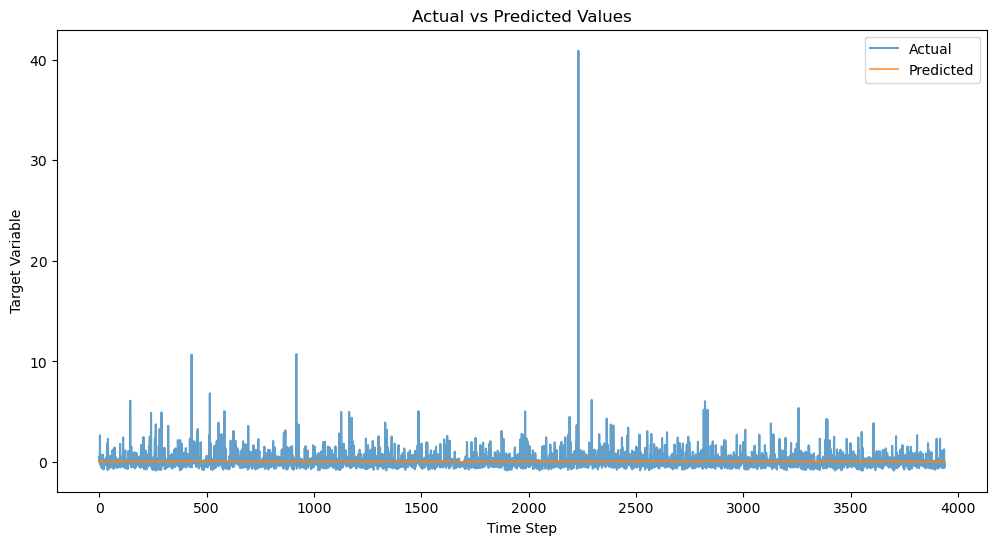

In [48]:
# plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(test_targets, label='Actual', alpha=0.7)
plt.plot(test_predictions, label='Predicted', alpha=0.7)
plt.legend()
plt.title("Actual vs Predicted Values")
plt.xlabel("Time Step")
plt.ylabel("Target Variable")
plt.show()

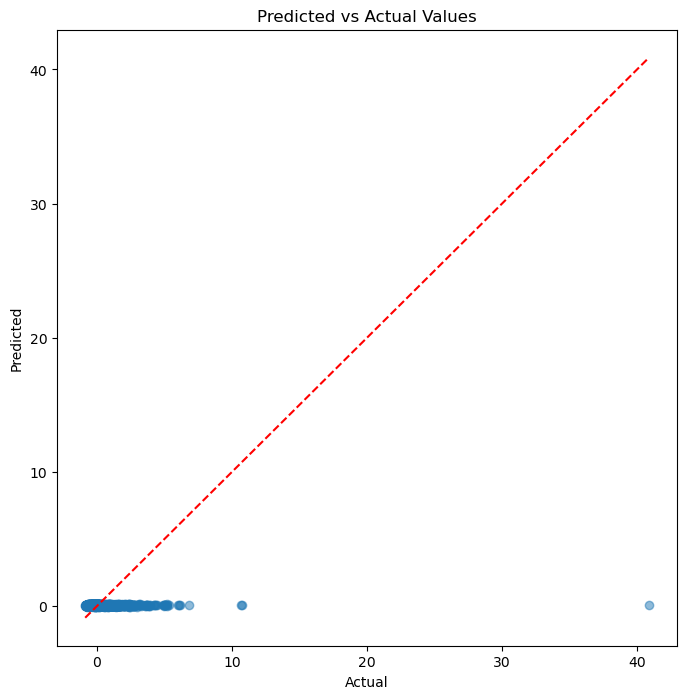

In [49]:
plt.figure(figsize=(8, 8))
plt.scatter(test_targets, test_predictions, alpha=0.5)
plt.plot([min(test_targets), max(test_targets)], [min(test_targets), max(test_targets)], 'r--')  # Diagonal line
plt.title("Predicted vs Actual Values")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

#### Save model

In [ ]:
torch.save(model.state_dict(), "lstm_model.pth")

In [ ]:
# load model
# model.load_state_dict(torch.load("lstm_model.pth"))
# model.eval()  # Set to evaluation mode

In [17]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_len, :-1]
        y = self.data[idx+self.seq_len, -1]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

seq_len = 10
dataset = TimeSeriesDataset(data, seq_len)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

#### Define the LSTM model

Create the LSTM-based regression model in PyTorch:

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)  # LSTM outputs (out, hidden_state)
        out = self.fc(out[:, -1, :])  # Use the last time step's output
        return out

# Model parameters
input_dim = data.shape[1] - 1  # Number of predictors
hidden_dim = 50
output_dim = 1  # Predicting `annual$`
num_layers = 2

model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers)

Define loss and optimizer:

In [15]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Train the model

In [16]:
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for batch_idx, (X_batch, y_batch) in enumerate(dataloader):
        optimizer.zero_grad()  # Reset gradients
        y_pred = model(X_batch)  # Forward pass
        loss = criterion(y_pred, y_batch.unsqueeze(1))  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss / len(dataloader):.4f}")

InvalidIndexError: (slice(20588, 20598, None), slice(None, -1, None))

### Make predictions

In [ ]:
model.eval()
with torch.no_grad():
    test_seq = torch.tensor(test_data[:seq_len, :-1], dtype=torch.float32).unsqueeze(0)
    prediction = model(test_seq)
    print(f"Predicted Value: {prediction.item()}")